# Chapter 12 - Introducing deep learning for time series forecasting

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from pathlib import Path

from matplotlib import pyplot as plt, dates as mdates
from matplotlib.ticker import StrMethodFormatter

import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# omd
import datetime
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt
import omdutils as omd

importlib.reload(tt)
importlib.reload(omd)

path = Path('/home/oliver/Documents/Data')
print('timetools version: {}'.format(tt.__version__))
print('omdutils version: {}'.format(omd.__version__))
print('statsmodels version: {}'.format(sm.__version__))

timetools version: 10.09.2022
omdutils version: 8.6.2022
statsmodels version: 0.13.2


In [2]:
# run this cell only once to save dataset in database 
df = pd.read_csv('../data/Metro_Interstate_Traffic_Volume.csv')
df.head()
omd.to_sqlite(df, 'Metro_Interstate_Traffic_Volume', str(path / 'Datasets'))

In [3]:
# run this cell only once to save dataset in database 
df = pd.read_csv('../data/metro_interstate_traffic_volume_preprocessed.csv')
df.head()
omd.to_sqlite(df, 'metro_interstate_traffic_volume_preprocessed', str(path / 'Datasets'))

In [2]:
df = omd.from_sqlite('select * from metro_interstate_traffic_volume_preprocessed', str(path / 'Datasets'))
df['date_time'] = pd.to_datetime(df['date_time'])
# df.reset_index('date_time', inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17551 entries, 0 to 17550
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       17551 non-null  datetime64[ns]
 1   temp            17551 non-null  float64       
 2   rain_1h         17551 non-null  float64       
 3   snow_1h         17551 non-null  int64         
 4   clouds_all      17551 non-null  int64         
 5   traffic_volume  17551 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 822.8 KB


,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0,0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0,0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0,0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0,0,2443.0


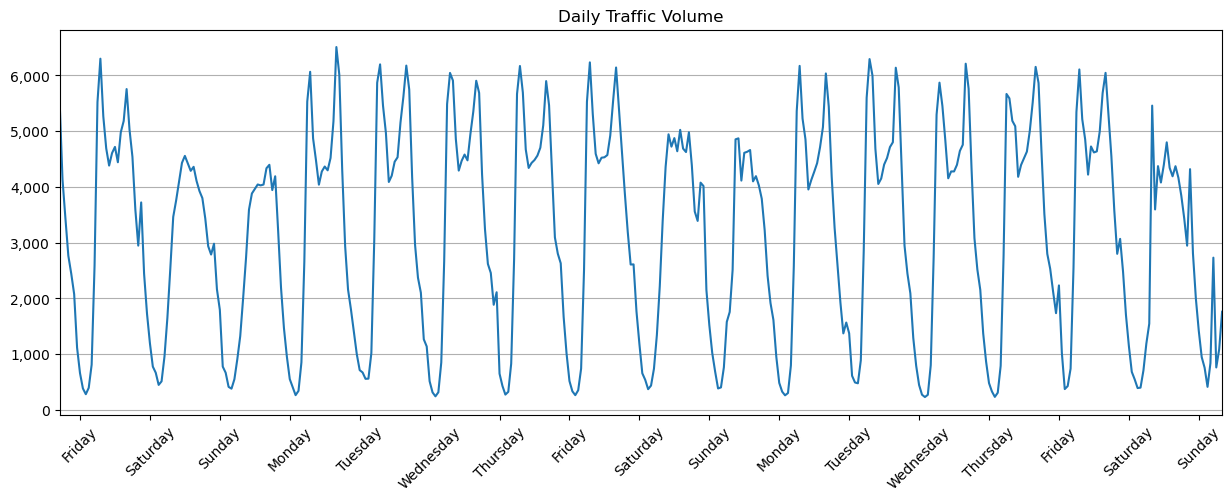

In [3]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df[:400]['date_time'], df[:400]['traffic_volume'])
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%A'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.margins(x=0)
ax.grid(axis='y')
ax.set_title('Daily Traffic Volume')
plt.show()

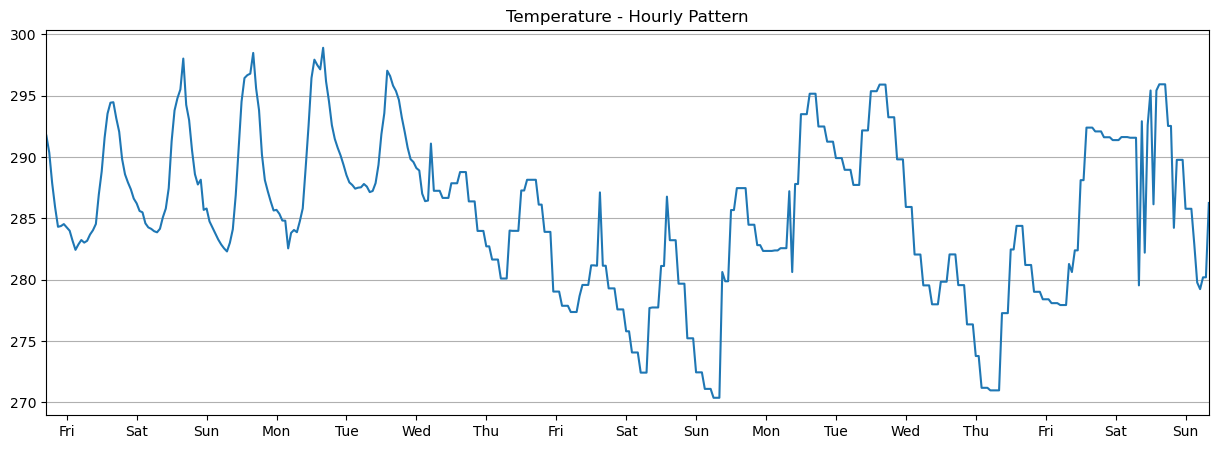

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df[:400]['date_time'], df[:400]['temp'])
ax.set_title('Temperature - Hourly Pattern')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
ax.margins(x=0)
ax.grid(axis='y')
plt.show()

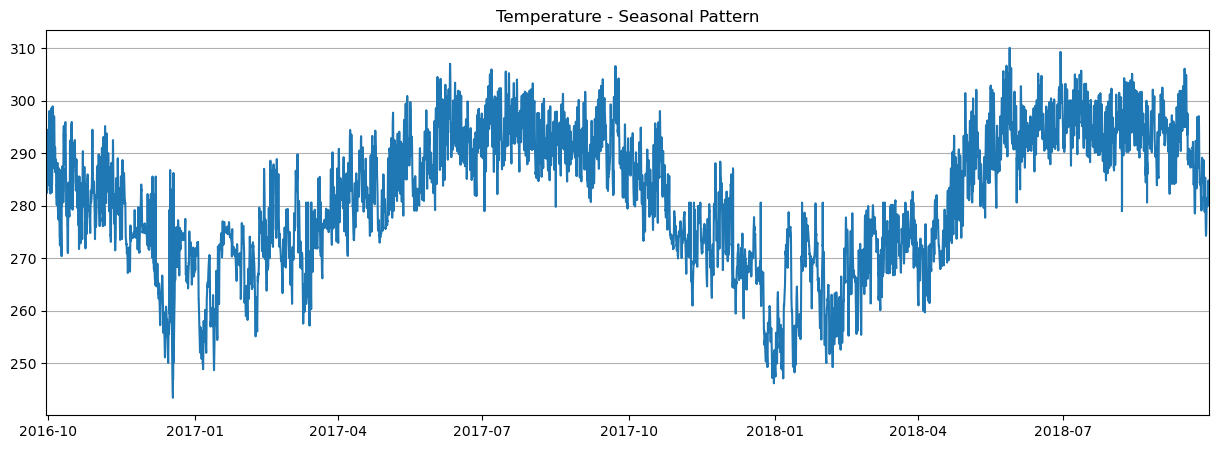

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))
temp = df[(df['date_time']>=datetime.datetime(2016,7,1)) ]
ax.plot(temp['date_time'], temp['temp'])
ax.set_title('Temperature - Seasonal Pattern')
ax.margins(x=0)
ax.grid(axis='y')
plt.show()

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


## Drop columns with little information

In [7]:
cols_to_drop = ['rain_1h', 'snow_1h']
df.drop(columns=cols_to_drop, axis=1, inplace=True)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


## Convert date_time to a numerical feature

In [9]:
df['date_time'].describe()

count                   17551
unique                  17551
top       2016-09-29 17:00:00
freq                        1
first     2016-09-29 17:00:00
last      2018-09-30 23:00:00
Name: date_time, dtype: object

In [11]:
df

,date_time,temp,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0,5551.0
1,2016-09-29 18:00:00,290.36,0,4132.0
2,2016-09-29 19:00:00,287.86,0,3435.0
3,2016-09-29 20:00:00,285.91,0,2765.0
4,2016-09-29 21:00:00,284.31,0,2443.0
...,...,...,...,...
17546,2018-09-30 19:00:00,283.45,75,3543.0
17547,2018-09-30 20:00:00,282.76,90,2781.0
17548,2018-09-30 21:00:00,282.73,90,2159.0
17549,2018-09-30 22:00:00,282.09,90,1450.0


In [12]:
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

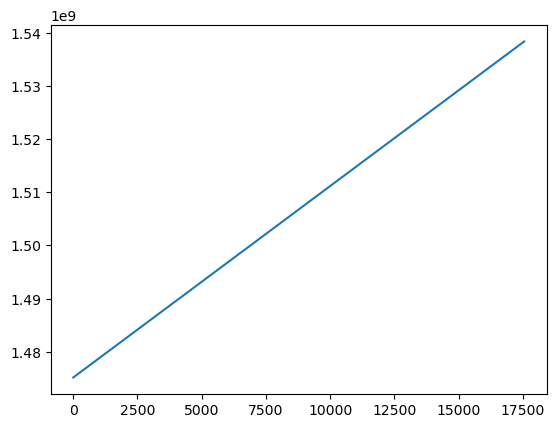

In [13]:
timestamp_s
plt.plot(timestamp_s);

## Sine transformation of timestamp

In [14]:
# number of seconds in a day
day = 24 * 60 * 60
day

86400

In [15]:
df['day_sin'] = (np.sin(timestamp_s * (2 * np.pi/day))).values

In [16]:
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
df.drop(columns=['date_time'], axis=1, inplace=True)

In [17]:
df

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,291.75,0,5551.0,-7.071068e-01,0.707107
1,290.36,0,4132.0,-5.000000e-01,0.866025
2,287.86,0,3435.0,-2.588190e-01,0.965926
3,285.91,0,2765.0,-6.611980e-12,1.000000
4,284.31,0,2443.0,2.588190e-01,0.965926
...,...,...,...,...,...
17546,283.45,75,3543.0,-2.588190e-01,0.965926
17547,282.76,90,2781.0,-7.593937e-12,1.000000
17548,282.73,90,2159.0,2.588190e-01,0.965926
17549,282.09,90,1450.0,5.000000e-01,0.866025


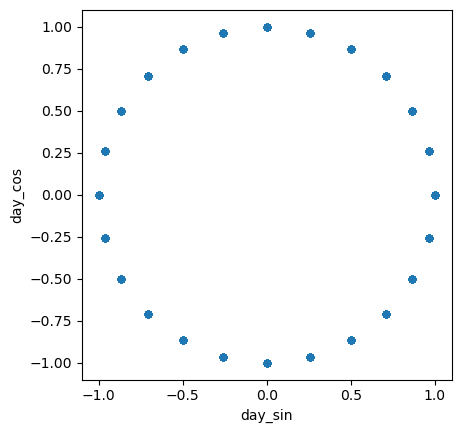

In [20]:
df.sample(5000).plot.scatter('day_sin', 'day_cos').set_aspect('equal')

## Split dataset into train, validation, and test  

|train | validation | test |  
|:----:|:----------:|:----:|  
|70    |     20     |  10  |   

In [22]:
n = len(df)
# split 70:20:10
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

## Scale data between 0 and 1
This will improve performance and decreases time required for training deep learning models  

In [24]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
scaler.fit(df_train)
df_train[df_train.columns] = scaler.transform(df_train[df_train.columns])
df_val[df_val.columns] = scaler.transform(df_val[df_val.columns])
df_test[df_test.columns] = scaler.transform(df_test[df_test.columns])

In [25]:
df_train

,temp,clouds_all,traffic_volume,day_sin,day_cos
0,0.760019,0.00,0.758755,0.146447,0.853553
1,0.738174,0.00,0.560765,0.250000,0.933013
2,0.698884,0.00,0.463513,0.370590,0.982963
3,0.668238,0.00,0.370029,0.500000,1.000000
4,0.643093,0.00,0.325101,0.629410,0.982963
...,...,...,...,...,...
12280,0.422599,0.90,0.599972,0.250000,0.066987
12281,0.421656,0.75,0.561881,0.146447,0.146447
12282,0.436272,0.90,0.567881,0.066987,0.250000
12283,0.439415,0.75,0.644482,0.017037,0.370590


In [26]:
df_train.to_csv('../data/train.csv')
df_val.to_csv('../data/val.csv')
df_test.to_csv('../data/test.csv')